In [1]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import json

MODEL = "EleutherAI/gpt-j-6B"

generator = pipeline("text-generation", model=MODEL, device="cuda", truncation=True)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("imdb")

print(dataset)
print(dataset['train'][0])

imdb = dataset['train']

pd_imdb =  imdb.to_pandas()

new_column_names = {'text': 'Text', 'label': 'Sentiment'}
pd_imdb = pd_imdb.rename(columns=new_column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [3]:
# Load Original Dataset and Contrast Set
original_set = pd.read_csv('Dataset/test_original.tsv', sep='\t')
contrast_set = pd.read_csv('Dataset/test_contrast.tsv', sep='\t')

# Load Original Dataset and Contrast Set
prompt_original_set = pd.read_csv('Dataset/dev_original.tsv', sep='\t')
prompt_contrast_set = pd.read_csv('Dataset/dev_contrast.tsv', sep='\t')


# Change Labels from 'Positive' to 1 and from 'Negative' to 0
original_set['Sentiment'] = original_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
contrast_set['Sentiment'] = contrast_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
prompt_original_set['Sentiment'] = prompt_original_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})
prompt_contrast_set['Sentiment'] = prompt_contrast_set['Sentiment'].replace({'Negative': 0, 'Positive': 1})


print(original_set.head())
print()
print(contrast_set.head())

   Sentiment                                               Text
0          0  A spoiler.<br /><br />What three words can gua...
1          0  The premise of this awaited sequel was really ...
2          0  The wonderful "Z" Channel in Los Angeles showe...
3          1  Carl Brashear (Cuba Gooding, Jr.) was born to ...
4          1  This slick and gritty film consistently delive...

   Sentiment                                               Text
0          1  A spoiler.<br /><br />What three words can gua...
1          1  The premise of this awaited sequel was really ...
2          1  The wonderful "Z" Channel in Los Angeles showe...
3          0  Carl Brashear (Cuba Gooding, Jr.) was born to ...
4          0  This slick and gritty film consistently fails ...


In [4]:
print(len(original_set))
print(len(prompt_original_set))

488
100


In [5]:
count = 0
for i in range(len(original_set)):
    if original_set.iloc[0].at['Text'] in pd_imdb['Text'].values:
        count += 1

if count == len(original_set):
    print(f'OK: {count}')

OK: 488


In [6]:
import random
def build_example(dataset, index):
    return f"""TEXT: {dataset['Text'][index]}
SENTIMENT: {["NEGATIVE", "POSITIVE"][dataset['Sentiment'][index]]}
"""

def get_build_prompt(dataset, shots=3):
    def build_prompt(sent):
        ret = ""
        '''
        if prompt_defintion and shots >0:
            ret += 'Classify the Sentiment of the TEXT. You can only choose between NEGATIVE or POSITIVE. Here you have some examples:\n\n'
        elif prompt_defintion:
            ret += 'Classify the Sentiment of the TEXT. You can only choose between NEGATIVE or POSITIVE:\n'
        '''
        
        indexes = random.sample(range(0, len(dataset)-1), shots)
        for index in indexes:
            ret += build_example(dataset, index)+"\n"
        ret += f"TEXT: {sent}\n"
        ret += "SENTIMENT:"

        return ret
    
    return build_prompt

prompt = get_build_prompt(prompt_contrast_set, shots=5)
print(len(prompt("This is my sentence")))

3992


In [7]:
def inference(*, prompt, sentence, generator):
    input = prompt(sentence)
    generated = generator(input, max_new_tokens=5, pad_token_id=generator.tokenizer.eos_token_id)[0]['generated_text']
    generated = generated.replace(input, "").strip()
    output = generated.split("\n")[0]

    if "NEGATIVE" in output:
        return 0
    elif "POSITIVE" in output:
        return 1
    else:
        #print("Model is confused... generated text: ", generated)
        return 0

print(inference(prompt=prompt, sentence="I love you", generator=generator))

1


In [8]:
import torch
from tqdm import tqdm
from transformers import pipeline
from sklearn.metrics import classification_report

@torch.no_grad()
def eval(dataset, prompt_dataset):
    overall_results = dict()

    for shots in [0, 1, 3, 5]:
        print("Running shot", shots)

        prompt = get_build_prompt(prompt_dataset, shots=shots)


        total = len(dataset)
        targets = []
        predictions = []

        for i in tqdm(range(total), total=total):
            targets.append(dataset['Sentiment'][i])
            predictions.append(inference(prompt=prompt, sentence=dataset['Text'][i], generator=generator))
            if i >= total:
                break
    
        report = classification_report(targets, predictions, output_dict=True)
        overall_results[shots] = report

    return overall_results

In [9]:
results_original_set = eval(dataset=original_set, prompt_dataset=prompt_original_set)

with open('origin_results.json', 'w') as f:
    json.dump(results_original_set, f, sort_keys=True, indent=4)

Running shot 0


  2%|▏         | 9/488 [00:02<01:45,  4.55it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [01:52<00:00,  4.33it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn

Running shot 1


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [02:23<00:00,  3.40it/s]


Running shot 3


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [03:24<00:00,  2.39it/s]


Running shot 5


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [04:34<00:00,  1.78it/s]


In [10]:
results_contrast_set = eval(dataset=contrast_set, prompt_dataset=prompt_contrast_set)

with open('contrast_results.json', 'w') as f:
    json.dump(results_contrast_set, f, sort_keys=True, indent=4)

Running shot 0


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [01:53<00:00,  4.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Running shot 1


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [02:26<00:00,  3.34it/s]


Running shot 3


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [03:28<00:00,  2.34it/s]


Running shot 5


  0%|          | 0/488 [00:00<?, ?it/s]/home/CristianCosci/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 488/488 [04:40<00:00,  1.74it/s]


In [11]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

performance_original = []
performance_contrast = []

for shot, report in results_original_set.items():
    performance_original.append(dict(shot=shot, accuracy=report["accuracy"]))

for shot, report in results_contrast_set.items():
    performance_contrast.append(dict(shot=shot, accuracy=report["accuracy"]))


In [12]:
total = []
indexes = []
original_result = [performance_original[x]['accuracy'] for x in range(len(performance_original))]
contrast_result = [performance_contrast[x]['accuracy'] for x in range(len(performance_contrast))]
shots_list = [str(x)+' Shots' for x in [y['shot'] for y in performance_contrast]]

for i in range(len(original_result)):
    total.append(original_result[i])
    total.append(contrast_result[i])
    indexes.append(shots_list[i])
    indexes.append(shots_list[i]+' C')

print(total)
print(indexes)

[0.4979508196721312, 0.5020491803278688, 0.6823770491803278, 0.6721311475409836, 0.7950819672131147, 0.7192622950819673, 0.8422131147540983, 0.7479508196721312]
['0 Shots', '0 Shots C', '1 Shots', '1 Shots C', '3 Shots', '3 Shots C', '5 Shots', '5 Shots C']


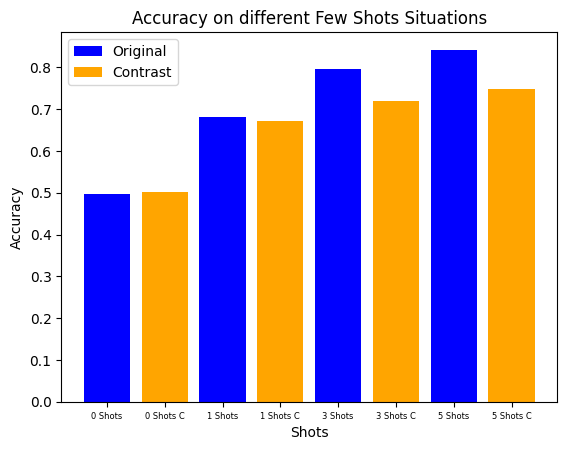

In [13]:
plt.bar([i for i in range(len(indexes)) if i % 2 == 0], [total[i] for i in range(len(indexes)) if i % 2 == 0], color='blue', label='Original')
plt.bar([i for i in range(len(indexes)) if i % 2 != 0], [total[i] for i in range(len(indexes)) if i % 2 != 0], color='orange', label='Contrast')
plt.xticks(ticks = [i for i in range(len(indexes))], labels=[indexes[i] for i in range(len(indexes))], fontsize=6)

plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()